In [ ]:
!nvidia-smi

Sat Sep 26 17:44:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Импорт библиотек

Данные https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate

In [ ]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

import gensim


# Подготовка данных

In [ ]:
# загрузка данных

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/mmad_mipt/hw1_b3/hw2_data/data.csv')
df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ


In [ ]:
# проверим на null значения 

print(len(df))

df.info()

60000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            60000 non-null  int64 
 1   Title         60000 non-null  object
 2   Body          60000 non-null  object
 3   Tags          60000 non-null  object
 4   CreationDate  60000 non-null  object
 5   Y             60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


In [ ]:
# дропнем некоторые признаки

df = df.drop(['Id', 'Tags', 'CreationDate'], axis = 1)
df.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,LQ_CLOSE
1,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,LQ_EDIT
2,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,HQ
3,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,HQ
4,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",HQ


In [ ]:
#закодируем признак

df['Y'] = df['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
df.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,1
2,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
3,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
4,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2


In [ ]:
df['text'] =df['Title'] + ' ' + df['Body'] 

df_text = df['text'].copy()
df_text.head()

0    Java: Repeat Task Every Random Seconds <p>I'm ...
1    How to get all the child records from differen...
2    Why are Java Optionals immutable? <p>I'd like ...
3    Text Overlay Image with Darkened Opacity React...
4    Why ternary operator in swift is so picky? <p>...
Name: text, dtype: object

In [ ]:
df.head()

,Title,Body,Y,text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,1,How to get all the child records from differen...
2,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2,Why are Java Optionals immutable? <p>I'd like ...
3,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2,Text Overlay Image with Darkened Opacity React...
4,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2,Why ternary operator in swift is so picky? <p>...


In [ ]:
import spacy
import re

nlp = spacy.load("en")

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt)>2:
        return ' '.join(txt)

cleaned = (re.sub("[^A-Za-z]+",' ',str(row)).lower() for row in df['text'])

text = [cleaning(doc) for doc in nlp.pipe(cleaned, batch_size=5000)]
text[:3]

['java repeat task random second p m familiar repeat task n second java util timer java util timertask let want print hello world console random second unfortunately m bit rush don t code far help apriciate p',
 'child record different table base give parent would sql server have different table like select system select set select item select version system would n set foe set qill n item item n version system br n set br set br n item br item br n version systemid retrieve record set item set version item single storedprocedure',
 'java optional immutable p d like understand java optional design immutable thread safety p']

In [ ]:
# сплит данных и удаление специальных символов

data = [sentence.split() for sentence in text]
data[:3]

[['java',
  'repeat',
  'task',
  'random',
  'second',
  'p',
  'm',
  'familiar',
  'repeat',
  'task',
  'n',
  'second',
  'java',
  'util',
  'timer',
  'java',
  'util',
  'timertask',
  'let',
  'want',
  'print',
  'hello',
  'world',
  'console',
  'random',
  'second',
  'unfortunately',
  'm',
  'bit',
  'rush',
  'don',
  't',
  'code',
  'far',
  'help',
  'apriciate',
  'p'],
 ['child',
  'record',
  'different',
  'table',
  'base',
  'give',
  'parent',
  'would',
  'sql',
  'server',
  'have',
  'different',
  'table',
  'like',
  'select',
  'system',
  'select',
  'set',
  'select',
  'item',
  'select',
  'version',
  'system',
  'would',
  'n',
  'set',
  'foe',
  'set',
  'qill',
  'n',
  'item',
  'item',
  'n',
  'version',
  'system',
  'br',
  'n',
  'set',
  'br',
  'set',
  'br',
  'n',
  'item',
  'br',
  'item',
  'br',
  'n',
  'version',
  'systemid',
  'retrieve',
  'record',
  'set',
  'item',
  'set',
  'version',
  'item',
  'single',
  'storedproced

# W2V Training

In [ ]:
# инициализация модели word2vec из gensim
 
%%time

w2v = gensim.models.Word2Vec(sentences = data, 
                             size = 100, 
                             window = 5, 
                             min_count=5, 
                             workers=2, 
                             sg=1, 
                             iter=50) 

CPU times: user 33min 25s, sys: 3.17 s, total: 33min 28s
Wall time: 17min 7s


In [ ]:
w2v.wv.vocab.keys()

dict_keys(['java', 'repeat', 'task', 'random', 'second', 'p', 'm', 'familiar', 'n', 'util', 'timer', 'timertask', 'let', 'want', 'print', 'hello', 'world', 'console', 'unfortunately', 'bit', 'rush', 'don', 't', 'code', 'far', 'help', 'child', 'record', 'different', 'table', 'base', 'give', 'parent', 'would', 'sql', 'server', 'have', 'like', 'select', 'system', 'set', 'item', 'version', 'foe', 'br', 'retrieve', 'single', 'storedprocedure', 'optional', 'immutable', 'd', 'understand', 'design', 'thread', 'safety', 'text', 'overlay', 'image', 'darken', 'opacity', 'react', 'native', 'attempt', 'title', 'low', 'effect', 'change', 'make', 'dim', 'fix', 'look', 'href', 'https', 'stack', 'imgur', 'com', 'png', 'rel', 'noreferrer', 'img', 'src', 'alt', 'enter', 'description', 'custom', 'component', 'article', 'preview', 'row', 'pre', 'touchable', 'require', 'follow', 'rss', 'feed', 'api', 'user', 's', 'keyword', 'interest', 'parse', 'home', 'js', 'db', 'need', 'augment', 'include', 'heart', 'pre

In [ ]:
w2v.wv.most_similar('like') # группы

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('look', 0.8592133522033691),
 ('want', 0.7961488366127014),
 ('suppose', 0.7307726144790649),
 ('achieve', 0.7295372486114502),
 ('possible', 0.7231950163841248),
 ('p', 0.7153090238571167),
 ('basically', 0.7045873999595642),
 ('need', 0.692182719707489),
 ('ideally', 0.6851645708084106),
 ('different', 0.6787875890731812)]

In [ ]:
w2v.wv.most_similar('specific') # группы

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('certain', 0.8803999423980713),
 ('particular', 0.8563554286956787),
 ('need', 0.8015799522399902),
 ('different', 0.7887187004089355),
 ('want', 0.7788064479827881),
 ('able', 0.7734100818634033),
 ('multiple', 0.7659564018249512),
 ('possible', 0.7480884790420532),
 ('automatically', 0.6913139224052429),
 ('separate', 0.6909336447715759)]

In [ ]:
w2v.wv['java']

array([ 0.2863491 , -0.5346695 ,  0.42320853, -0.6297302 , -0.09233854,
       -0.53716433,  0.08279633,  0.29528022,  0.17158557,  0.15957099,
       -0.446581  , -0.23186843,  0.21016791, -0.30650458, -0.10663574,
        0.11225975, -0.19369543,  0.5820484 ,  0.31070623,  0.09261546,
        0.3863062 ,  0.13655803,  0.25376126,  0.07548015, -0.00615803,
        0.10613091, -0.01549126, -0.09852593, -0.19939072, -0.10110451,
       -0.17798184,  0.09657893, -0.6408893 , -0.04773084, -0.6864054 ,
        0.43723932,  0.13563599, -0.23249383,  0.59795046,  0.2816645 ,
        0.39463103,  0.3830907 , -0.1362139 , -0.26353163, -0.532632  ,
        0.27930966, -0.9160082 ,  0.5149413 , -0.28564787, -0.4761716 ,
        0.2474049 ,  0.28250238,  0.22961296, -0.08518718,  0.12167169,
       -0.22804756, -0.33661222,  0.04712947,  1.2767174 ,  0.35033727,
       -0.06723252,  0.16313651,  0.1978615 ,  0.23063995,  0.75636184,
       -0.10477555,  0.53380734, -0.12630117,  0.4047197 ,  0.15

In [ ]:
# сохраним модель
w2v.save('mymodel.vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# TSNE visualization

In [ ]:
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def plot_tsne(model, word, list_names):

    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # TSNE
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization')
    

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


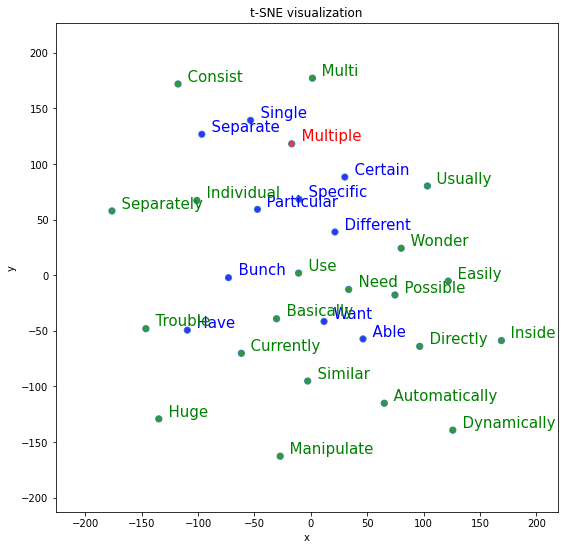

In [ ]:
plot_tsne(w2v, 'multiple',[t[0] for t in w2v.wv.most_similar('multiple', topn=30)][10:])

# Попытка использовать свой w2v

Не разобрался, как применить свой w2v, мы не доделали это на семинаре( вот кусок попытки, в обучении буду использовать претрененный

In [ ]:
labales = df['Y'].copy().to_numpy()
df_res = pd.DataFrame(text, columns=['Text']) 
df_res['Y'] = labales 
df_res.head()

,Text,Y
0,java repeat task random second p m familiar re...,0
1,child record different table base give parent ...,1
2,java optional immutable p d like understand ja...,2
3,text overlay image darken opacity react native...,2
4,ternary operator swift picky p question simple...,2


In [ ]:
# train-test split
train = df_res[:int(len(labeles)*0.8)]
test = df_res[int(len(labeles)*0.8):]

In [ ]:
train.head()

,Text,Y
0,java repeat task random second p m familiar re...,0
1,child record different table base give parent ...,1
2,java optional immutable p d like understand ja...,2
3,text overlay image darken opacity react native...,2
4,ternary operator swift picky p question simple...,2


In [ ]:
data_vocab = []

for sentence in tqdm(train['Text'].to_list()):
    for word in sentence.split():
        if word in data_vocab:
            pass
        else:
            data_vocab.append(word)
data_vocab

100%|██████████| 48000/48000 [06:09<00:00, 129.97it/s]


['java',
 'repeat',
 'task',
 'random',
 'second',
 'p',
 'm',
 'familiar',
 'n',
 'util',
 'timer',
 'timertask',
 'let',
 'want',
 'print',
 'hello',
 'world',
 'console',
 'unfortunately',
 'bit',
 'rush',
 'don',
 't',
 'code',
 'far',
 'help',
 'apriciate',
 'child',
 'record',
 'different',
 'table',
 'base',
 'give',
 'parent',
 'would',
 'sql',
 'server',
 'have',
 'like',
 'select',
 'system',
 'set',
 'item',
 'version',
 'foe',
 'qill',
 'br',
 'systemid',
 'retrieve',
 'single',
 'storedprocedure',
 'optional',
 'immutable',
 'd',
 'understand',
 'design',
 'thread',
 'safety',
 'text',
 'overlay',
 'image',
 'darken',
 'opacity',
 'react',
 'native',
 'attempt',
 'title',
 'low',
 'effect',
 'change',
 'make',
 'dim',
 'fix',
 'look',
 'href',
 'https',
 'stack',
 'imgur',
 'com',
 'hzd',
 'png',
 'rel',
 'noreferrer',
 'img',
 'src',
 'alt',
 'enter',
 'description',
 'custom',
 'component',
 'article',
 'preview',
 'row',
 'pre',
 'touchable',
 'require',
 'follow',
 'rs

In [ ]:
vocab_size = len(data_vocab)

In [ ]:
from tqdm import tqdm

weights_matrix = np.zeros((vocab_size, 100))
words_found = 0

for i, word in tqdm(enumerate(data_vocab)):
    try: 
        weights_matrix[i] = w2v.wv[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))

139036it [00:01, 118750.65it/s]


In [ ]:
weights_matrix[:3]

array([[ 0.28634909, -0.53466952,  0.42320853, -0.62973022, -0.09233854,
        -0.53716433,  0.08279633,  0.29528022,  0.17158557,  0.15957099,
        -0.44658101, -0.23186843,  0.21016791, -0.30650458, -0.10663574,
         0.11225975, -0.19369543,  0.58204842,  0.31070623,  0.09261546,
         0.3863062 ,  0.13655803,  0.25376126,  0.07548015, -0.00615803,
         0.10613091, -0.01549126, -0.09852593, -0.19939072, -0.10110451,
        -0.17798184,  0.09657893, -0.64088929, -0.04773084, -0.68640542,
         0.43723932,  0.13563599, -0.23249383,  0.59795046,  0.28166449,
         0.39463103,  0.3830907 , -0.1362139 , -0.26353163, -0.53263199,
         0.27930966, -0.91600817,  0.51494128, -0.28564787, -0.47617161,
         0.2474049 ,  0.28250238,  0.22961296, -0.08518718,  0.12167169,
        -0.22804756, -0.33661222,  0.04712947,  1.27671742,  0.35033727,
        -0.06723252,  0.16313651,  0.19786149,  0.23063995,  0.75636184,
        -0.10477555,  0.53380734, -0.12630117,  0.4

In [ ]:
embedding = nn.Embedding.from_pretrained(torch.FloatTensor(w2v.wv.vectors))
embedding(torch.LongTensor([0]))

tensor([[ 0.1606, -0.0243,  0.0445, -0.2694, -0.0413, -0.0499,  0.0152,  0.0385,
         -0.2116,  0.2317,  0.0074, -0.3756, -0.0068,  0.2967, -0.1624, -0.0248,
         -0.0741,  0.1775,  0.1977, -0.1191, -0.0134, -0.2462,  0.0290,  0.0704,
          0.3773,  0.1114, -0.1860, -0.1072,  0.0163,  0.1141, -0.0125, -0.0110,
         -0.1125, -0.1928,  0.0761,  0.1580,  0.1343,  0.1080,  0.2069,  0.0720,
          0.3693,  0.2119,  0.1090, -0.2186,  0.2864,  0.0505,  0.0538,  0.2921,
          0.0184,  0.0902,  0.0659,  0.1172,  0.0527, -0.0863, -0.0246,  0.2797,
          0.0173, -0.0465, -0.1603,  0.1470, -0.1312, -0.0963,  0.2223,  0.1854,
          0.2935,  0.0768, -0.2130, -0.0189,  0.1250,  0.1698, -0.1343,  0.0303,
         -0.2743,  0.2051,  0.1984, -0.0219,  0.0272, -0.0424, -0.1507, -0.4062,
          0.1818,  0.0261,  0.3347,  0.1508,  0.0256,  0.1994,  0.1593,  0.3170,
         -0.0093,  0.0578,  0.1242,  0.0639,  0.1003, -0.1348, -0.0094,  0.0100,
         -0.1764,  0.1387,  

С этого момента начадись проблемы, сроки поджимали, решил использовать претрененный, тем более, мой w2v не очень хорошо обучился, возможно из-за предобработки или из-за того, что это статьи из SOF, там много програмного кода и это портит модель.

# LSTM

Использую претрененный w2v

In [ ]:
import nltk
import torchtext
nltk.download('punkt')

text_data = torchtext.data.Field(tokenize=nltk.word_tokenize, lower=True, batch_first=True)
y = torchtext.data.Field(sequential=False, is_target=True, use_vocab=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# загрузка данных в торч

data = torchtext.data.TabularDataset(path='/content/df_res.csv', format='csv', 
                                     fields={
                                         'Text': ('Text', text_data),
                                         'Y': ('Y', y)
                                     })

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-09-26 18:10:53--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  9.50MB/s    in 70s     

2020-09-26 18:12:03 (9.35 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!unzip '/content/wiki-news-300d-1M.vec.zip' -d '/content/'

Archive:  /content/wiki-news-300d-1M.vec.zip
replace /content/wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
text_data.build_vocab(data)

In [ ]:
text_data.vocab.load_vectors(torchtext.vocab.Vectors('/content/wiki-news-300d-1M.vec'))

In [ ]:
text_data.vocab.vectors.shape

torch.Size([164388, 300])

In [ ]:
train, test = data.split(split_ratio= 0.8)

In [ ]:
len(train), len(test)

(48000, 12000)

In [ ]:
batch_size = 16
train_i = torchtext.data.BucketIterator(dataset=train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train =True)


test_i = torchtext.data.BucketIterator(dataset=test,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        sort = False,
                                        train = False)

In [ ]:
class lstm(nn.Module):
    def __init__(self, w2v, padding_inx, dropout, hidden_size):
        super(lstm, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(w2v)
        self.embedding.padding_inx = padding_inx

        self.embedding.weight.requires_grad = True

        self.dropout = nn.Dropout(p = dropout)
        self.lstm = nn.LSTM(input_size = self.embedding.embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = 2,
                            dropout = dropout,
                            bidirectional = True)
        self.label = nn.Linear(hidden_size*2*2, 3)

    def forward(self, sentence):
        x = self.embedding(sentence)
        x = torch.transpose(x, dim0 = 1, dim1 = 0)
        out, (hidden, c) = self.lstm(x)
        x = self.dropout(torch.cat([c[i,:,:] for i in range(c.shape[0])], dim=1))
        x = self.label(x)
        return F.log_softmax(x)

In [ ]:
model = lstm(text_data.vocab.vectors, text_data.vocab.stoi[text_data.pad_token], dropout = 0.2, hidden_size=128).cuda()

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [ ]:
def fit(epochs, model, loss_f, optimizer, train_i, val_i):

    train_losses = []
    valid_losses = []

    train_i.init_epoch()
    for epoch in range(epochs):

        train_loss = 0.0
        valid_loss = 0.0

        # тренировка модели
        for batch in iter(train_i):
            model.train()

            x = batch.Text.cuda()
            y = batch.Y.cuda()
            y = y.to(torch.long)

            model.zero_grad()
            preds = model.forward(x)
            loss = loss_f(preds, y)        
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y.size(0)

        # валидация 
        for batch in iter(test_i):
            model.eval()

            x = batch.Text.cuda()
            y = batch.Y.cuda()
            y = y.to(torch.long)

            preds = model.forward(x)
            loss = loss_f(preds, y)
            # обновляем validation-loss 
            valid_loss += loss.item() * y.size(0)

        # считаем средние потери
        train_loss = train_loss/(len(train_i) * 16) # 16 - batch_size
        valid_loss = valid_loss/(len(test_i) * 16) # 16 - batch_size
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # статистика по эпохам
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    


In [ ]:
%%time

#  тренировка модели 

fit(3, model, loss, optimizer, train_i, test_i)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 	Training Loss: 0.124975 	Validation Loss: 0.195791
Epoch: 1 	Training Loss: 0.063436 	Validation Loss: 0.278152
Epoch: 2 	Training Loss: 0.034644 	Validation Loss: 0.347219
CPU times: user 11min 28s, sys: 1min 23s, total: 12min 51s
Wall time: 12min 54s


In [ ]:
# посмотрим accuracy на тесте 

with torch.no_grad():
    correct = 0
    total = 0

    for batch in iter(test_i):

        # перенесём данные на gpu
        x = batch.Text.cuda()
        y = batch.Y.cuda()
        y = y.to(torch.long)
        # прямой проход
        preds = model(x)

        _, predicted = torch.max(preds.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy of the model: 91.10833333333333 %


Были постоянные проблемы с размерностями, но вроде всё пофиксил:) Видно, что за 3 эпохи модель переобучилась, но на тесте всё равно получили хорошую точность

# Seq2Seq

Seq2Seq так и не понял, как обучить для многоклассовой классификации, так как мы делеали только перевод(

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        """
        input_dim - это размер / размерность one hot векторов, которые будут вводиться в encoder. Равно размеру входного (исходного) словаря.
        emb_dim - это размерность слоя embedding-a. Этот слой преобразует one-hot векторы в сжатие векторы с размерами emb_dim.
        hid_dim - это размерность скрытого и cell состояний.
        n_layers - это количество слоев в RNN
        dropout - процент dropout
        """
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # src - предложения размера (src_len x batch_size)
        # embedded = <TODO> 
        embedded = self.embedding(src) # (src_len x batch_size x embd_dim)
        embedded = self.dropout(embedded) # dropout эмбеддингов
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        self.rnn = nn.LSTM(self.emb_dim, self.hid_dim, self.n_layers) # размер (lstm embd, hid, layers, dropout)
        self.out = nn.Linear(self.hid_dim, self.output_dim) # проекция hid_dim x output_dim
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_, hidden, cell):
        input_ = input_.unsqueeze(0) # 1 размер батча
        # (1 x batch_size x emb_dim)
        # эмбеддинг по input and dropout 
        embedded = self.embedding(input_) 
        embedded = self.dropout(embedded)
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        # batch_size x output_dim
        prediction = self.out(output.squeeze(0)) # проэкция из рнн на выходное

        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self._init_weights()  
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        '''
        src - входное предл (src_len x batch_size)
        trg - выходное предл
        teacher_forcing_ration - 0.5 вероятность получить реальный токен вместо предложенного
        '''
        
        batch_size = 1
        max_len = 3
        trg_vocab_size = self.decoder.output_dim
        
        # сохраняем выходы декодера 
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        # последнее скрытое энкодера используем как первый хидден декодера
        hidden, cell = self.encoder(src) #
        
        # первый инпут декодера - токен <sos> 
        input = trg[0, :]
        
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell) # передаем состояние и вход через декодер
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs
    
    def _init_weights(self):
        p = 0.08
        for name, param in self.named_parameters():
            nn.init.uniform_(param.data, -p, p)

In [ ]:
input_dim = len(text_data.vocab.vectors)
output_dim = 3
src_embd_dim =  tgt_embd_dim = 300
tgt_embd_dim = 1
hidden_dim = 512
num_layers =  4
dropout_prob = 0.2

batch_size = 16
PAD_IDX = text_data.vocab.stoi[text_data.pad_token]


enc = Encoder(input_dim, src_embd_dim, hidden_dim, num_layers, dropout_prob)
dec = Decoder(output_dim, tgt_embd_dim, hidden_dim, num_layers, dropout_prob)
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(164388, 300)
    (rnn): LSTM(300, 512, num_layers=4)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3, 1)
    (rnn): LSTM(1, 512, num_layers=4)
    (out): Linear(in_features=512, out_features=3, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [ ]:
def fit_s2s(model, epochs, train_i, test_i, optimizer, loss_f, clip):

    train_losses = []
    valid_losses = []
    train_i.init_epoch()

    for epoch in range(epochs):

        model.train()
        train_loss = 0.0
        valid_loss = 0.0
    
        for batch in iter(train_i):
        
            x = batch.Text.cuda()
            y = batch.Y.cuda()
            y = y.to(torch.long)
        
            optimizer.zero_grad()
            preds = model(x, y)
            preds = preds[1:].view(-1, preds.shape[-1])
            y = y[1:].view(-1)
            loss = loss_f(preds, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            train_loss += loss.item() * y.size(0)
        
        for batch in iter(test_i):
            model.eval()

            x = batch.Text.cuda()
            y = batch.Y.cuda()
            y = y.to(torch.long)

            preds = model(x, y)
            preds = preds[1:].view(-1, preds.shape[-1])
            y = y[1:].view(-1)
            loss = loss_f(preds, y)
            # обновляем validation-loss 
            valid_loss += loss.item() * y.size(0)

        
        # считаем средние потери
        train_loss = train_loss/(len(train_i) * 16) # 16 - batch_size
        valid_loss = valid_loss/(len(test_i) * 16) # 16 - batch_size
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # статистика по эпохам
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    


In [ ]:
fit_s2s(model, 3,  train_i, test_i, optimizer, loss, 1)

IndexError: ignored